<a href="https://colab.research.google.com/github/zyberg2091/Recognized-named-entities-in-twitter/blob/master/Recognize_Named_entities_in_twitter_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input,Dense,SpatialDropout1D,Embedding,Bidirectional,LSTM,TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [4]:
def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            if token.lower().startswith("https://"):
              token='<URL>'
            if token.lower().startswith("@"):
              token='<USR>'
          
            
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    return tokens, tags

In [5]:
train_tokens, train_tags = read_data('data/train.txt')
validation_tokens, validation_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

In [6]:
train_tokens[:2]

[['RT',
  '<USR>',
  ':',
  'Online',
  'ticket',
  'sales',
  'for',
  'Ghostland',
  'Observatory',
  'extended',
  'until',
  '6',
  'PM',
  'EST',
  'due',
  'to',
  'high',
  'demand',
  '.',
  'Get',
  'them',
  'before',
  'they',
  'sell',
  'out',
  '...'],
 ['Apple',
  'MacBook',
  'Pro',
  'A1278',
  '13.3',
  '"',
  'Laptop',
  '-',
  'MD101LL/A',
  '(',
  'June',
  ',',
  '2012',
  ')',
  '-',
  'Full',
  'read',
  'by',
  'eBay',
  'http://t.co/2zgQ99nmuf',
  'http://t.co/eQmogqqABK']]

In [7]:
for i in range(3):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
http://t.co/2zgQ99nmuf	O
http://t.co/eQmogqqABK	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



In [8]:
from collections import defaultdict

In [9]:
def build_dict(tokens_or_tags,i):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    
    # Create mappings from tokens (or tags) to indices and vice versa.
    # At first, add special tokens (or tags) to the dictionaries.
    # The first special token must have index 0.
    
    # Mapping tok2idx should contain each token or tag only once. 
    # To do so, you should:
    # 1. extract unique tokens/tags from the tokens_or_tags variable, which is not
    #    occur in special_tokens (because they could have non-empty intersection)
    # 2. index them (for example, you can add them into the list idx2tok
    # 3. for each token/tag save the index into tok2idx).

    vocab=set([t for ts in tokens_or_tags for t in ts])
    
    if i==0:
        tok2idx['<PAD>']=0
        tok2idx['<UNK>']=1
        idx2tok.append('<UNK>')
        idx2tok.append('<PAD>')
    if i==1:
        tok2idx['0']=0
        idx2tok.append('0')


    for key,value in enumerate(vocab):
      if i==0:
        tok2idx[value]=key+2
        idx2tok.append(value)
      if i==1:
        tok2idx[value]=key+1
        idx2tok.append(value)

  
    return tok2idx, idx2tok

In [10]:

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens,0)
tag2idx, idx2tag = build_dict(train_tags,1)

In [11]:
def words2idxs(tokens_list):
    return [token2idx[word] if word in token2idx.keys() else token2idx['<UNK>'] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] if tag in tag2idx.keys() else tag2idx['0'] for tag in tags_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

def idxs2tags(idxs):
    return [idx2tag[idx] for idx in idxs]

In [12]:
count=[]
for i in range(len(train_tokens)):
  count.append(len(train_tokens[i]))
length=max(count)

In [13]:
#Data prep

x_train=[words2idxs(token) for token in train_tokens]
x_train_pad=pad_sequences(x_train,maxlen=length,value=token2idx['<PAD>'],padding="post")


y_train=[tags2idxs(tags) for tags in train_tags]
y_train_pad=pad_sequences(y_train,maxlen=length,value=tag2idx['0'],padding="post")

y_train_data=[to_categorical(y,num_classes=len(idx2tag)+1) for y in y_train_pad]

In [14]:
s=[[1,2,3,4],[23,5,6,7]]
pad_sequences(s,maxlen=10,value=0)


array([[ 0,  0,  0,  0,  0,  0,  1,  2,  3,  4],
       [ 0,  0,  0,  0,  0,  0, 23,  5,  6,  7]], dtype=int32)

In [15]:
x_val=[words2idxs(token) for token in validation_tokens]
x_val_pad=pad_sequences(x_val,maxlen=length,value=token2idx['<PAD>'],padding="post")

y_val=[tags2idxs(tags) for tags in validation_tags]
y_val_pad=pad_sequences(y_val,maxlen=length,value=tag2idx['0'],padding="post")

y_val_data=[to_categorical(y,num_classes=len(idx2tag)+1) for y in y_val_pad]

In [16]:
y_train_data=np.array(y_train_data)

In [17]:
x_train_pad.shape,y_train_data.shape

((5795, 41), (5795, 41, 23))

In [18]:
#model architecture

i=Input(shape=(41,))
x=Embedding(len(idx2token)+1,64)(i)
x=SpatialDropout1D(0.1)(x)
x=Bidirectional(LSTM(64,return_sequences=True,recurrent_dropout=0.1))(x)
x=TimeDistributed(Dense(len(idx2tag)+1,activation='softmax'))(x)


model=Model(i,x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 41, 64)            1344832   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 41, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 128)           66048     
_________________________________________________________________
time_distributed (TimeDistri (None, 41, 23)            2967      
Total params: 1,413,847
Trainable params: 1,413,847
Non-trainable params: 0
_________________________________________________________________


In [19]:
idx2tokens={value:key for key,value in token2idx.items()}
idx2tags={value:key for key,value in tag2idx.items()}
idx2tags

{0: '0',
 1: 'B-musicartist',
 2: 'I-sportsteam',
 3: 'I-tvshow',
 4: 'I-company',
 5: 'B-product',
 6: 'B-company',
 7: 'I-facility',
 8: 'O',
 9: 'B-tvshow',
 10: 'I-geo-loc',
 11: 'I-musicartist',
 12: 'I-product',
 13: 'I-person',
 14: 'I-other',
 15: 'I-movie',
 16: 'B-person',
 17: 'B-movie',
 18: 'B-geo-loc',
 19: 'B-sportsteam',
 20: 'B-facility',
 21: 'B-other'}

In [20]:
r=model.fit(x_train_pad,y_train_data,validation_data=(x_val_pad,np.array(y_val_data)),epochs=10,verbose=1)

Epoch 1/10
182/182 [==============================] - 48s 262ms/step - loss: 0.5302 - accuracy: 0.8867 - val_loss: 0.2060 - val_accuracy: 0.9695
Epoch 2/10
182/182 [==============================] - 49s 267ms/step - loss: 0.2015 - accuracy: 0.9677 - val_loss: 0.1757 - val_accuracy: 0.9699
Epoch 3/10
182/182 [==============================] - 48s 265ms/step - loss: 0.1623 - accuracy: 0.9679 - val_loss: 0.1459 - val_accuracy: 0.9699
Epoch 4/10
182/182 [==============================] - 48s 262ms/step - loss: 0.1235 - accuracy: 0.9691 - val_loss: 0.1342 - val_accuracy: 0.9718
Epoch 5/10
182/182 [==============================] - 47s 261ms/step - loss: 0.1014 - accuracy: 0.9724 - val_loss: 0.1321 - val_accuracy: 0.9724
Epoch 6/10
182/182 [==============================] - 47s 259ms/step - loss: 0.0882 - accuracy: 0.9760 - val_loss: 0.1350 - val_accuracy: 0.9729
Epoch 7/10
182/182 [==============================] - 49s 267ms/step - loss: 0.0763 - accuracy: 0.9792 - val_loss: 0.1377 - val_ac

In [21]:
x_val_pad

array([[    1,     1, 17874, ...,     0,     0,     0],
       [ 6890, 14394, 19859, ...,     0,     0,     0],
       [12452, 20347, 14283, ...,     0,     0,     0],
       ...,
       [12042, 17495, 17882, ...,     0,     0,     0],
       [    1,     1, 16449, ...,     0,     0,     0],
       [14394, 13931,  4659, ...,     0,     0,     0]], dtype=int32)

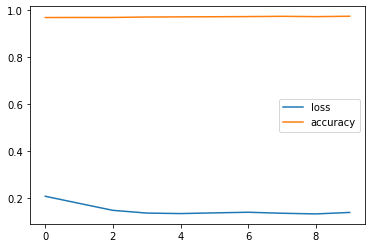

In [22]:
plt.plot(r.history['val_loss'],label='loss')
plt.plot(r.history['val_accuracy'],label='accuracy')
plt.legend()

In [25]:
#predictions
predictions=model.predict(x_val_pad)

In [26]:
y_pred=np.argmax(predictions,axis=-1)

In [27]:
y_true=np.array(y_val_data).argmax(axis=-1)
y_true.shape

(724, 41)

In [28]:
x_val_pad[1].shape,y_pred.shape[1],y_true.shape[1]

((41,), 41, 41)

In [29]:
for i,j,k in zip(x_val_pad[70],y_true[70],y_pred[70]):
  print("{}---------------------{}------{}".format(idx2tokens[i],idx2tags[j],idx2tags[k]))

1---------------------O------O
MO---------------------O------O
DAY---------------------O------O
TO---------------------O------O
GO---------------------O------O
<UNK>---------------------O------O
&gt;---------------------O------O
<UNK>---------------------O------O
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<PAD>---------------------0------0
<